
# Hidden Markov Model (HMM) Based Trading Strategy for S&P 500

This project implements a trading strategy for the S&P 500 index (^GSPC) using a Hidden Markov Model (HMM). The strategy identifies market regimes and generates trading signals based on these regimes, incorporating a stop-loss mechanism based on volatility.

## Methodology

### Data Preparation

1.  **Load Data**: The S&P 500 data from January 1, 2017, to December 31, 2023, was downloaded using the `yfinance` library. The adjusted closing prices and daily returns were calculated.
    
2.  **Calculate Rolling Volatility**: Rolling volatility was calculated using a 20-day window to measure the standard deviation of returns.
    
3.  **Split Data**: The data was split into training (80%) and testing (20%) sets.
    

### Hidden Markov Model (HMM) Training

1.  **Prepare Data for HMM**: The returns were reshaped to be suitable for training the HMM.
    
2.  **Train HMM**: A Gaussian HMM with 2 hidden states was trained on the training data. The model was set to run for 1000 iterations or until convergence.
    
3.  **Predict Regimes**: The trained HMM was used to predict regimes for both the training and testing sets.
    

### Trading Signal Generation

1.  **Identify "Good" Regime**: The regime with the highest average returns was identified as the "good" regime.
    
2.  **Generate Trading Signals**: Trading signals were generated based on the identified "good" regime, where positions were taken when the market was in the "good" regime.
    

### Backtesting Strategy with Stop-Loss

1.  **Backtest with Initial Capital**: The strategy was backtested with an initial capital of $100,000, incorporating trading costs and a stop-loss mechanism. The stop-loss was set as a multiple of the rolling volatility to manage risk.

## Performance Metrics

### Calculate Metrics

Performance metrics were calculated for both training and testing sets. These metrics included:

-   **Sharpe Ratio**: Measures the risk-adjusted return of the portfolio.
-   **Total Return**: The overall return of the portfolio over the period.
-   **Annualized Return**: The return of the portfolio annualized over the period.
-   **Number of Trades**: The total number of trades executed by the strategy.

The performance metrics provided insights into the effectiveness and robustness of the trading strategy.

[*********************100%%**********************]  1 of 1 completed


Training Set Metrics
Sharpe Ratio: 1.8068582525526837
Total Return: 838.22%
Annualized Return: 59.59%
Number of Trades: 40.0

Testing Set Metrics
Sharpe Ratio: 2.08689236650353
Total Return: 132.92%
Annualized Return: 102.49%
Number of Trades: 9.0

Initial Portfolio Value for Testing Set: 100000.0

First 5 days of the testing set:
             Returns  Signal  Position           Cash      Portfolio
Date                                                                
2022-10-18  0.006645       1       0.0  100000.000000  100000.000000
2022-10-19  0.007019       1       1.0  100000.000000  100000.000000
2022-10-20  0.011866       1       1.0  101186.629890  101186.629890
2022-10-21  0.022306       1       1.0  103443.684324  103443.684324
2022-10-24  0.010669       1       1.0  104547.342076  104547.342076


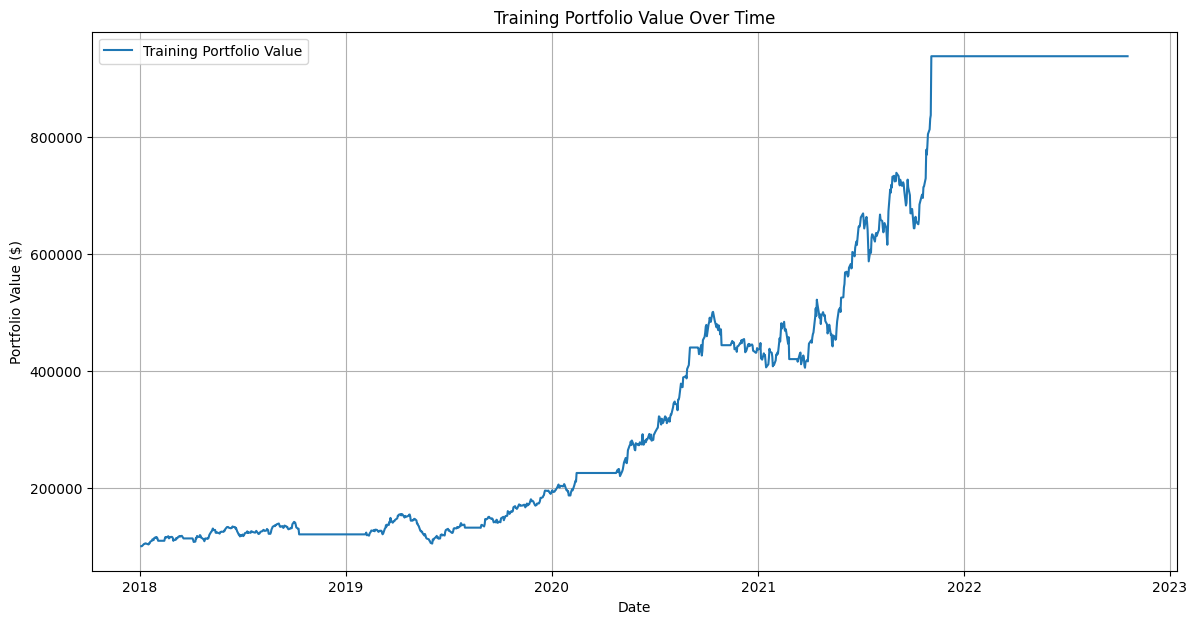

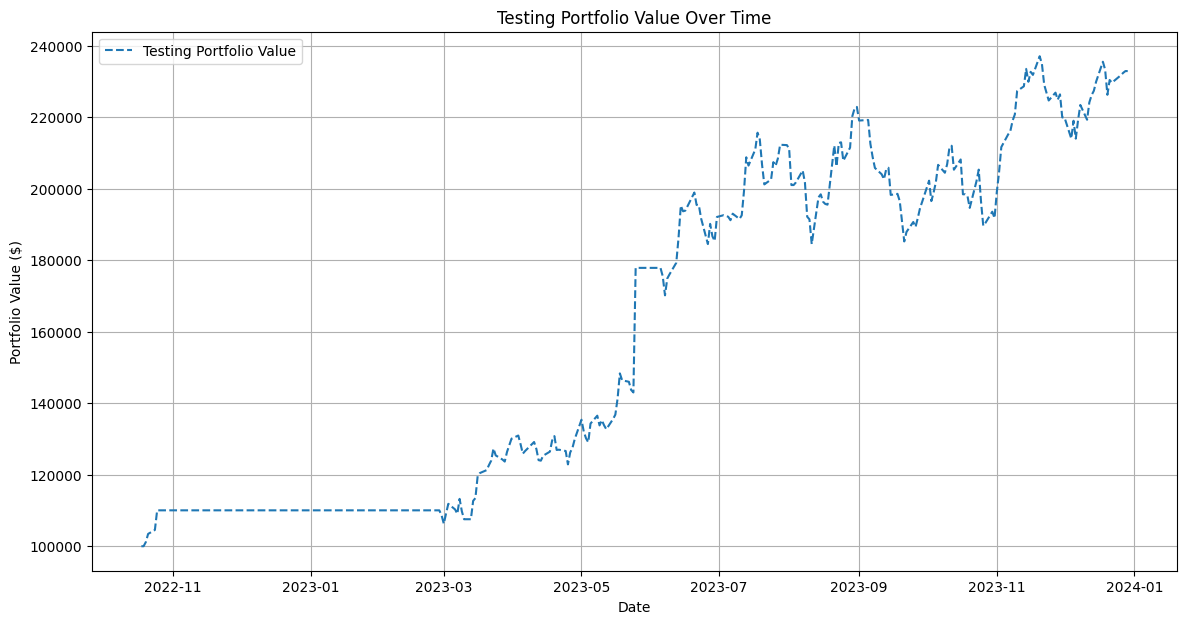

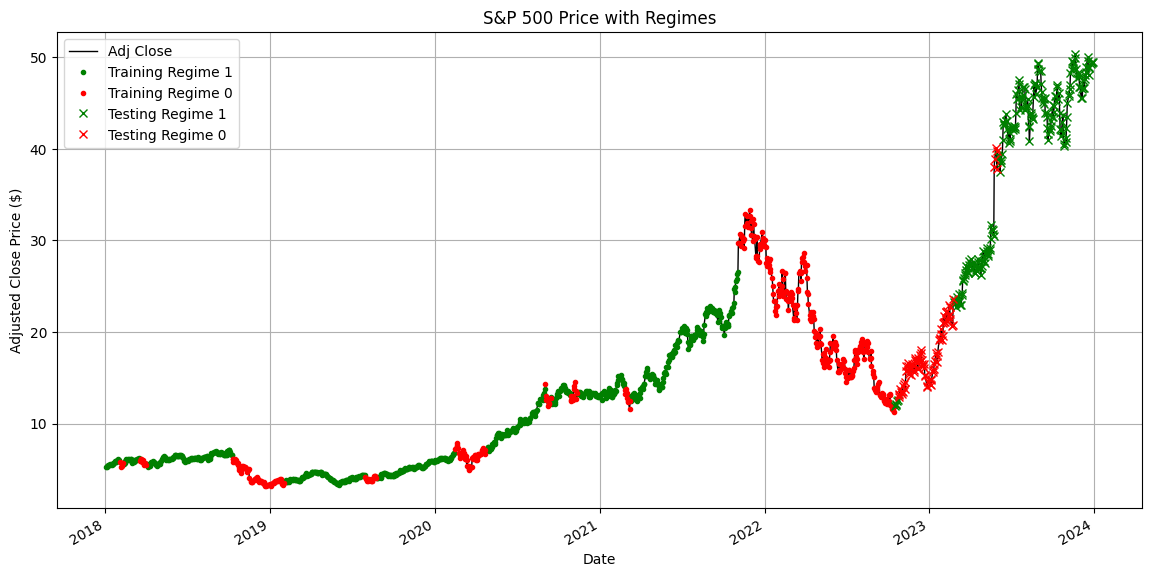

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
ticker = "NVDA"
start_date = "2018-01-01"
end_date = "2024-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Adj Close']].copy()
data['Returns'] = data['Adj Close'].pct_change()
data = data.dropna()

# Calculate rolling volatility (standard deviation)
data['Volatility'] = data['Returns'].rolling(window=20).std()

# Split data into training and testing sets (80% training, 20% testing)
split_date = data.index[int(0.8 * len(data))]
train_data = data[:split_date].copy()
test_data = data[split_date:].copy()

# Prepare data for HMM
train_returns = train_data['Returns'].values.reshape(-1, 1)
test_returns = test_data['Returns'].values.reshape(-1, 1)

# Train HMM
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
hmm_model.fit(train_returns)

# Predict regimes on training and testing sets
train_hidden_states = hmm_model.predict(train_returns)
test_hidden_states = hmm_model.predict(test_returns)

# Add hidden states to the dataframes
train_data['Regime'] = train_hidden_states
test_data['Regime'] = test_hidden_states

# Identify the "good" regime based on average returns
train_data['Regime_Returns'] = train_data.groupby('Regime')['Returns'].transform('mean')
good_regime = train_data.groupby('Regime')['Regime_Returns'].mean().idxmax()

# Generate trading signals based on the identified "good" regime
train_data['Signal'] = np.where(train_data['Regime'] == good_regime, 1, 0)
test_data['Signal'] = np.where(test_data['Regime'] == good_regime, 1, 0)

# Backtest the strategy with stop-loss based on volatility
initial_capital = 100000
trading_cost = 0.03
stop_loss_multiplier = 2  # You can adjust this value as needed

def backtest_with_stop_loss(data, initial_capital, stop_loss_multiplier):
    data['Position'] = data['Signal'].shift(1)
    data['Position'] = data['Position'].fillna(0)
    data['Cash'] = initial_capital  # Initialize cash
    data['Cash'] = data['Cash'].astype(float)  # Ensure the 'Cash' column is float

    # Implement stop-loss
    data['Stop_Loss'] = -stop_loss_multiplier * data['Volatility']

    for i in range(1, len(data)):
        if data['Returns'].iloc[i] < data['Stop_Loss'].iloc[i] or data['Signal'].iloc[i] == 0:
            data.loc[data.index[i], 'Position'] = 0  # Exit position if stop-loss or bad regime
            data.loc[data.index[i], 'Cash'] = data['Cash'].iloc[i - 1] * (1 + data['Returns'].iloc[i] * data['Position'].iloc[i - 1]) - trading_cost
        else:
            data.loc[data.index[i], 'Cash'] = data['Cash'].iloc[i - 1] * (1 + data['Returns'].iloc[i] * data['Position'].iloc[i - 1])

    data['Portfolio'] = data['Cash']
    return data

train_data = backtest_with_stop_loss(train_data, initial_capital, stop_loss_multiplier)
test_data = backtest_with_stop_loss(test_data, initial_capital, stop_loss_multiplier)

# Calculate performance metrics
def calculate_metrics(data):
    sharpe_ratio = data['Portfolio'].pct_change().mean() / data['Portfolio'].pct_change().std() * np.sqrt(252)
    total_return = data['Portfolio'].iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (1 / (len(data) / 252)) - 1
    number_of_trades = data['Position'].diff().abs().sum()
    return sharpe_ratio, total_return, annualized_return, number_of_trades

train_metrics = calculate_metrics(train_data)
test_metrics = calculate_metrics(test_data)

print("Training Set Metrics")
print(f"Sharpe Ratio: {train_metrics[0]}")
print(f"Total Return: {train_metrics[1] * 100:.2f}%")
print(f"Annualized Return: {train_metrics[2] * 100:.2f}%")
print(f"Number of Trades: {train_metrics[3]}")

print("\nTesting Set Metrics")
print(f"Sharpe Ratio: {test_metrics[0]}")
print(f"Total Return: {test_metrics[1] * 100:.2f}%")
print(f"Annualized Return: {test_metrics[2] * 100:.2f}%")
print(f"Number of Trades: {test_metrics[3]}")

# Print initial portfolio value for testing set
print("\nInitial Portfolio Value for Testing Set:", test_data['Portfolio'].iloc[0])

# Debugging: Print the first 5 days of the testing set
print("\nFirst 5 days of the testing set:")
print(test_data[['Returns', 'Signal', 'Position', 'Cash', 'Portfolio']].head(5))

# Plot portfolio value for training set
plt.figure(figsize=(14, 7))
plt.plot(train_data['Portfolio'], label='Training Portfolio Value')
plt.title('Training Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.savefig('OutputHMM/training_portfolio_value.png')
plt.show()

# Plot portfolio value for testing set
plt.figure(figsize=(14, 7))
plt.plot(test_data['Portfolio'], label='Testing Portfolio Value', linestyle='--')
plt.title('Testing Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.savefig('OutputHMM/testing_portfolio_value.png')
plt.show()

# Plot stock price with regimes for training and testing sets
fig, ax = plt.subplots(figsize=(14, 7))
data['Adj Close'].plot(ax=ax, color='black', lw=1)
regime_colors = {0: 'red', 1: 'green'}

for regime in train_data['Regime'].unique():
    mask = train_data['Regime'] == regime
    ax.plot(train_data.index[mask], train_data['Adj Close'][mask], linestyle='None', marker='.', color=regime_colors[regime], label=f'Training Regime {regime}')

for regime in test_data['Regime'].unique():
    mask = test_data['Regime'] == regime
    ax.plot(test_data.index[mask], test_data['Adj Close'][mask], linestyle='None', marker='x', color=regime_colors[regime], label=f'Testing Regime {regime}')

ax.set_title('S&P 500 Price with Regimes')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price ($)')
ax.legend()
plt.grid()
plt.savefig('OutputHMM/stock_price_with_regimes.png')
plt.show()
